In [18]:
# !pip install wget
# !pip install openpyxl
# !pip install mapie

In [6]:
import os
import wget
import zipfile
from os.path import exists

# Download if not available
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"
if not exists(bean_data_file):
    filename = "DryBeanDataset.zip"

url = base + dataset_number + "/" + filename
wget.download(url)
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')

os.remove(filename)

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB

# Read in the data from Excel file
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)

# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])

# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)

# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(
    X, y, train_size=10000, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
    X_rest1, y_rest1, train_size=1000, random_state=42
)
# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
    X_rest2, y_rest2, train_size=1000, random_state=42
)
# Fit the model
model = GaussianNB().fit(X_train, y_train)

In [8]:
from sklearn.metrics import confusion_matrix

# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

Accuracy: 0.758
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        46       0    47         0      6      0     4
BOMBAY           0      33     0         0      0      0     0
CALI            20       0    81         0      3      0     0
DERMASON         0       0     0       223      0     32     9
HOROZ            0       0     4         3    104      0    22
SEKER            2       0     0        26      1    127    22
SIRA             0       0     0        10     10     21   144


In [9]:
# Size of calibration data
n = len(X_calib)
# Get the probability predictions
predictions = model.predict_proba(X_calib)
# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]
# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

In [10]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# Define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level, method='higher')

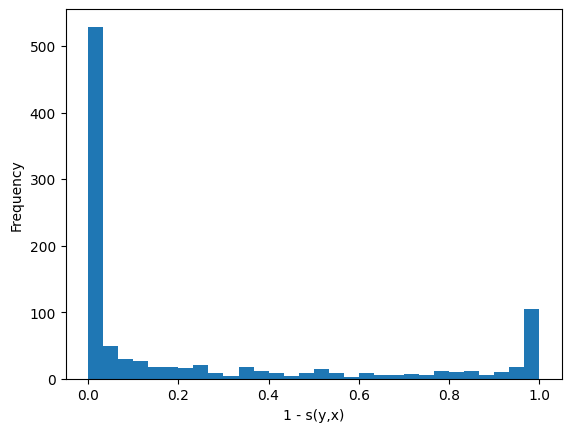

In [11]:
import matplotlib.pyplot as plt

# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()

In [12]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [13]:
for i in range(3):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']


In [17]:
from mapie.metrics import classification_coverage_score
from mapie.metrics import classification_mean_width_score

y_set = np.squeeze(prediction_sets)
cov = classification_coverage_score(y_new, y_set)
setsize = classification_mean_width_score(y_set)
print('Coverage: {:.2%}'.format(cov))
print('Avg. set size: {:.2f}'.format(setsize))

Coverage: 96.34%
Avg. set size: 1.84
